In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1-Vm4Y4YTPSH_zM3xSTzB9RQvJqiVFwaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-Vm4Y4YTPSH_zM3xSTzB9RQvJqiVFwaw
To: /content/Tumor.zip
100% 156M/156M [00:03<00:00, 43.5MB/s]


In [2]:
!pip install segmentation-models
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install patool
import patoolib
patoolib.extract_archive('Tumor.zip')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 6.3 MB/s eta 0:00:00
patool: Extracting Tumor.zip ...
patool: running /usr/bin/7z x -o./Unpack_ii5wmimp -- Tumor.zip
patool: ... Tumor.zip extracted to `Tumor'.


'Tumor'

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
# from keras.applications.resnet import ResNet34
from keras.applications.inception_v3 import InceptionV3

In [5]:
SIZE = 128

train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/Tumor/Training/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
print(len(train_images))        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

pituitary
notumor
meningioma
glioma
5712


In [6]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/Tumor/Testing/*"):
    fruit_label = directory_path.split("/")[-1]
    print(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
print(len(test_images))            
test_images = np.array(test_images)
test_labels = np.array(test_labels)

pituitary
notumor
meningioma
glioma
1311


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)


In [8]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [9]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [10]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
	layer.trainable = False
VGG_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [13]:
feature_extractor=VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

179/179 [==============================] - 17s 50ms/step


In [14]:
X_for_RF = features #This is our X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [15]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [16]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

41/41 [==============================] - 3s 80ms/step


In [17]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [19]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.9298245614035088


              precision    recall  f1-score   support

      glioma       0.94      0.82      0.88       300
  meningioma       0.85      0.89      0.87       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.92      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



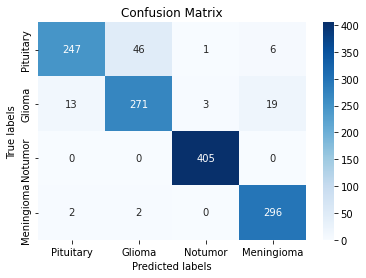

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt   
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report
ax= plt.subplot()
cm = confusion_matrix(test_labels,  prediction_RF)
#print(cm)

sns.heatmap(cm, annot=True,cmap="Blues",fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]); 
ax.yaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]);
d = {'Expected': test_labels, 'Predicted':  prediction_RF}
results = pd.DataFrame(data=d)
print(classification_report(results['Expected'], results['Predicted']))
     

1/1 [==============================] - 1s 562ms/step
The prediction for this image is:  ['notumor']
The actual label for this image is:  notumor


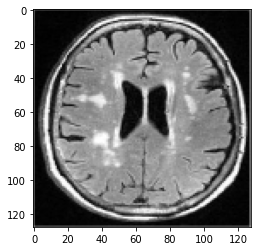

In [21]:
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])